# X gate calibration with sync hook on IQCC

This notebook demonstrates how to set up and run a reinforcement learning (RL) environment for calibrating an X gate on a quantum computer using a sync hook with IQCC. The RL agent interacts with the quantum environment to optimize the gate parameters for improved performance.

The core components of this setup include:
- **Quantum Backend**: The quantum computer backend is configured using IQCC, which provides access to the hardware and its capabilities. Behind the scenes, we leverage a powerful Qiskit-to-QUA compiler, enabling the creation of fully parametric quantum circuits, adjustable in real-time through control-flow statements and carefully chosen pulse-level parameters.
- **Parametrized Circuit**: A custom parametrized quantum circuit is defined, which includes the X gate to be calibrated. This circuit is executed on the quantum backend. In general, this parametrization is done in QUA directly, in such a way that we can leverage the full power of the Pulse Processing Unit (OPX).
- **Action Space**: The action space for the RL agent is defined, specifying the range of parameters that the agent can explore.
- **Reward Function**: A reward function is implemented to provide feedback to the agent based on the performance of the gate.
- **Environment Configuration**: The quantum environment is configured with the target gate (or target state), action space, and execution parameters.
- **Sync Hook**: A sync hook is generated to facilitate communication between the RL agent and the quantum backend during training.
- **Training Execution**: The RL training process is executed, where the agent learns to
optimize the X gate parameters through interactions with the quantum environment.


In [2]:
import base64
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, Gate
from typing import List
from gymnasium.spaces import Box
from rl_qoc.qua import QMEnvironment, QMConfig
from rl_qoc.qua.iqcc import *
from iqcc_calibration_tools.quam_config.components import Quam, Transmon
from qiskit_qm_provider import (
    FluxTunableTransmonBackend,
    QMInstructionProperties,
    InputType,
    ParameterPool,
)
from qiskit_qm_provider.backend.backend_utils import add_basic_macros_to_machine
from rl_qoc.agent.ppo_config import (
    TotalUpdates,
    TrainingConfig,
)
from rl_qoc import (
    RescaleAndClipAction,
    ChannelReward,
    StateReward,
    CAFEReward,
    ExecutionConfig,
    QEnvConfig,
    BenchmarkConfig,
    StateTarget,
    GateTarget,
    PPOConfig,
)
from rl_qoc.helpers import add_custom_gate
from rl_qoc.helpers import load_from_yaml_file

import json
import os
import sys
from pathlib import Path

from rl_qoc.qua.pi_pulse_reward.pi_pulse_reward import PiPulseReward
from rl_qoc.qua.qua_ppo import CustomQMPPO

/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/helpers/__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")


2025-08-27 11:05:20,052 - qm - INFO     - Starting session: e06a7d23-537c-4be0-afea-5adef542bd1f
2025-08-27 11:05:20 INFO Starting session: e06a7d23-537c-4be0-afea-5adef542bd1f


In [3]:
# Set your quantum computer backend
path = Path.home() / "iqcc_token.json"
with open(path, "r") as f:
    iqcc_config = json.load(f)

backend_name = "gilboa"
machine, iqcc = get_machine_from_iqcc(backend_name, iqcc_config[backend_name])

add_basic_macros_to_machine(machine, "active")
backend = FluxTunableTransmonBackend(machine)
print(backend.target)


Target: Qiskit Backend for Quantum Abstract Machine (Quam)
Number of qubits: 2
Instructions:
	x
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
		(1,):
			Duration: 0 sec.
			Error Rate: 0
	sx
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
	delay
		(0,):
		(1,):
	reset
		(0,):
			Duration: 7.66e-06 sec.
		(1,):
			Duration: 7.66e-06 sec.
	measure
		(0,):
			Duration: 1.65e-06 sec.
		(1,):
			Duration: 1.65e-06 sec.
	sy
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
	sydg
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
	id
		(0,):
			Duration: 0 sec.
			Error Rate: 0
		(1,):
			Duration: 0 sec.
			Error Rate: 0
	cz
		(1, 0)
	if_else
	while_loop
	for_loop
	switch_case
	box



/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/backend/backend_utils.py:215: UserWarning: Could not add default two qubit gates. Add it manually if necessary.
  warnings.warn("Could not add default two qubit gates. Add it manually if necessary.")
/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/backend/flux_tunable_transmon_backend.py:52: UserWarning: qiskit.pulse is not available, channel mapping will not be set.
  warnings.warn("qiskit.pulse is not available, channel mapping will not be set.")


In [4]:
path = "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/sync_hook_iqcc/x_cal"
agent_config_path = os.path.join(path, "agent_config.yaml")
ppo_config = load_from_yaml_file(agent_config_path)


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: List[Parameter], q_reg: QuantumRegister, **kwargs
):

    physical_qubits: List[int] = kwargs["physical_qubits"]
    backend: FluxTunableTransmonBackend = kwargs["backend"]

    # TODO: Enter your custom parametric QUA macro here
    def qua_macro(amp):
        qubit: Transmon = backend.get_qubit(physical_qubits[0])
        qubit.xy.play("x180", amplitude_scale=amp)

    # Create a custom gate with the QUA macro
    custom_x = Gate("x_cal", 1, params)
    instruction_prop = QMInstructionProperties(qua_pulse_macro=qua_macro)
    qc = add_custom_gate(qc, custom_x, q_reg, params, physical_qubits, backend, instruction_prop)
    return qc


physical_qubits = (0,)

target_name = "x"
target = GateTarget(gate=target_name, physical_qubits=physical_qubits)
reward =  ChannelReward()

target_name = "1"
target = StateTarget(state=target_name, physical_qubits=physical_qubits)
reward =  StateReward()


# Action space specification
param_bounds = [(-1.98, 2.0)]  # Can be any number of bounds

# Environment execution parameters
seed = 1203  # Master seed to make training reproducible
batch_size = 32  # Number of actions to evaluate per policy evaluation
n_shots = 1  # Minimum number of shots per fiducial evaluation
pauli_sampling = 50  # Number of fiducials to compute for fidelity estimation (DFE only)
n_reps = 1  # Number of repetitions of the cycle circuit
num_updates = TotalUpdates(100)
input_type = InputType.INPUT_STREAM # Choose mechanism of communication with OPX (can be DGX Quantum)


def create_action_space(param_bounds):
    param_bounds = np.array(param_bounds, dtype=np.float32)
    lower_bound, upper_bound = param_bounds.T
    return Box(low=lower_bound, high=upper_bound, shape=(len(param_bounds),), dtype=np.float32)


action_space = create_action_space(param_bounds)

backend_config = QMConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
    input_type=input_type,
    verbosity=0,
    parametrized_circuit_kwargs={"physical_qubits": physical_qubits, "backend": backend},
    num_updates=num_updates.total_updates,
)
execution_config = ExecutionConfig(
    batch_size=batch_size,
    sampling_paulis=pauli_sampling,
    n_shots=n_shots,
    n_reps=n_reps,
    seed=seed,
)
q_env_config = QEnvConfig(
    target=target,
    backend_config=backend_config,
    action_space=action_space,
    execution_config=execution_config,
    reward=reward,
    benchmark_config=BenchmarkConfig(0),
)  # No benchmark for now

q_env = QMEnvironment(training_config=q_env_config)
rescaled_env = RescaleAndClipAction(q_env, -1.0, 1.0)



/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


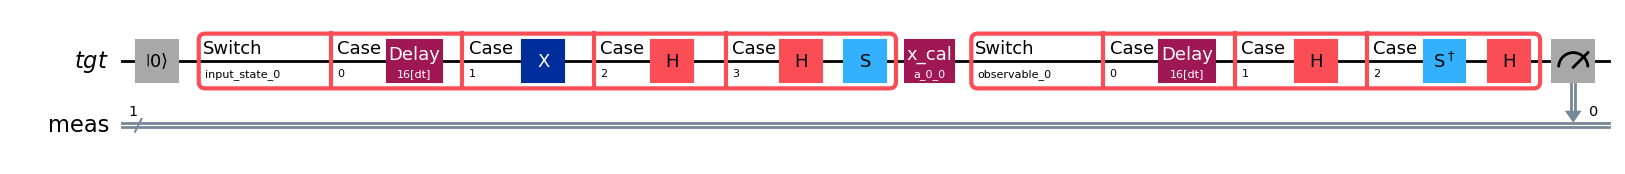

In [5]:
# Print quantum circuit executed on OPX
q_env.real_time_circuit.draw("mpl")

In [6]:
from qm import generate_qua_script

print(generate_qua_script(q_env.rl_qoc_training_qua_prog(num_updates=num_updates.total_updates)))


# Single QUA script generated at 2025-08-27 11:05:25.631894
# QUA library version: 1.2.2

from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    input_stream_input_state_0 = declare_input_stream(int, 'input_state_0', value=0)
    input_stream_observable_0 = declare_input_stream(int, 'observable_0', value=0)
    input_stream_pauli_shots = declare_input_stream(int, 'pauli_shots', value=1)
    input_stream_max_observables = declare_input_stream(int, 'max_observables', value=0)
    v1 = declare(fixed, value=0.0)
    input_stream_mu = declare_input_stream(fixed, 'mu', value=[0.0])
    input_stream_sigma = declare_input_stream(fixed, 'sigma', value=[1.0])
    a1 = declare(int, value=[0, 0])
    v2 = declare(int, )
    v3 = declare(int, )
    v4 = declare(int, )
    v5 = declare(int, )
    v6 = declare(int, )
    v7 = declare(int, )
    a2 = declare(fixed, size=1)
    a3 = declare(fixed, size=1)
    v8 = declare(int, value=1203)
    a4 = declare(fixed, value

In [7]:
sync_hook_path = generate_sync_hook(
    target=target,
    reward=reward,
    param_bounds=param_bounds,
    seed=seed,
    batch_size=batch_size,
    n_shots=n_shots,
    pauli_sampling=pauli_sampling,
    n_reps=n_reps,
    num_updates=num_updates,
    input_type=input_type,
    backend_config=backend_config,
    ppo_config=ppo_config,
    output_dir=path
    
)
print(f"Sync hook file generated at: {sync_hook_path}")


Sync hook file generated at: /Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/sync_hook_iqcc/x_cal/sync_hook.py


In [8]:
if hasattr(q_env.real_time_circuit, "calibrations") and q_env.real_time_circuit.calibrations:
    # Relevant for adding Qiskit Pulse based QUA macros (works only with Qiskit 1.x)
    backend.update_calibrations(qc=q_env.real_time_circuit, input_type=input_type)
backend.update_compiler_from_target()
prog = q_env.rl_qoc_training_qua_prog(num_updates=num_updates.total_updates)

In [9]:
run_data = iqcc.execute(
    prog,
    backend.qm_config,
    terminal_output=True,
    options={"sync_hook": sync_hook_path, "timeout": 600, "profiling": False},
)

/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/quam/quam/components/channels.py:636: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(


Output()

[11:05:27] QUA program submitted to gilboa (id = d4df9c34-8c2b-437d-bcbe-4a72e3aaaead)             ]8;id=679608;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=622474;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#426\426]8;;\

[11:05:28] Execution started                                                                       ]8;id=117915;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=429572;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#446\446]8;;\

[11:06:33] Execution finished                                                                      ]8;id=209625;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=813300;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#460\460]8;;\

QUA program has error:

/app/temp.py:8373: UserWarning: name 'result_handles' is not defined
  warnings.warn(str(e))
/app/temp.py:8378: UserWarning: name 'end_time' is not defined
  warnings.warn(str(e))

 👍     stdout:

 🚨     stderr:

/app/temp.py:8373: UserWarning: name 'result_handles' is not defined
  warnings.warn(str(e))
/app/temp.py:8378: UserWarning: name 'end_time' is not defined
  warnings.warn(str(e))

 ⚛️      result

{}

 🚀     sync-hook stdout:

mean [-0.11900815]
sigma [0.48835975]
DFE Rewards Mean: 0.46875
DFE Rewards standard dev 0.314838748409404
Returns Mean: 0.46875
Returns standard dev: 0.31483874
Advantages Mean: 0.4102107
Advantages standard dev 0.31483877
mean [-0.0657286]
sigma [0.4968968]
DFE Rewards Mean: 0.46437500000000004
DFE Rewards standard dev 0.2915790791106248
Returns Mean: 0.46437502
Returns standard dev: 0.29157907
Advantages Mean: 0.36152434
Advantages standard dev 0.29157907
mean [-0.04398534]
sigma [0.5087009]
DFE Rewards Mean: 0.471875
DFE Rewards standard dev 0.2986578048117946
Returns Mean: 0.471875
Returns standard dev: 0.2986578
Advantages Mean: 0.30100715
Advantages standard dev 0.2986578
mean [0.03245204]
sigma [0.5153962]
DFE Rewards Mean: 0.42374999999999996
DFE Rewards standard dev 0.3102997542699639
Returns Mean: 0.42375
Returns standard dev: 0.31029975
Advantages Mean: 0.1561955
Advantages standard dev 0.31029975
mean [0.15555291]
sigma [0.5267798]
DFE Rewards Mean: 0.48812500000000003
DFE Rewards standard dev 0.3187028151350408
Returns Mean: 0.48812503
Returns standard dev: 0.31870282
Advantages Mean: 0.104278475
Advantages standard dev 0.31870282
mean [0.2026409]
sigma [0.5329367]
DFE Rewards Mean: 0.5331250000000001
DFE Rewards standard dev 0.296251977841499
Returns Mean: 0.533125
Returns standard dev: 0.29625198
Advantages Mean: 0.06795685
Advantages standard dev 0.29625198
mean [0.10975771]
sigma [0.53576964]
DFE Rewards Mean: 0.4225
DFE Rewards standard dev 0.32510575202539865
Returns Mean: 0.4225
Returns standard dev: 0.32510576
Advantages Mean: -0.04826821
Advantages standard dev 0.32510576
mean [0.0349356]
sigma [0.544793]
DFE Rewards Mean: 0.575
DFE Rewards standard dev 0.28818396901979126
Returns Mean: 0.575
Returns standard dev: 0.28818396
Advantages Mean: 0.1282726
Advantages standard dev 0.28818396
mean [-0.06228931]
sigma [0.5585866]
DFE Rewards Mean: 0.411875
DFE Rewards standard dev 0.282305657709866
Returns Mean: 0.411875
Returns standard dev: 0.28230566
Advantages Mean: -0.07096682
Advantages standard dev 0.28230566
mean [-0.05465987]
sigma [0.54197985]
DFE Rewards Mean: 0.419375
DFE Rewards standard dev 0.29616230242048025
Returns Mean: 0.419375
Returns standard dev: 0.2961623
Advantages Mean: -0.048060425
Advantages standard dev 0.2961623
[2K
[2K
mean [-0.01851151]
sigma [0.5394262]
DFE Rewards Mean: 0.5449999999999999
DFE Rewards standard dev 0.3256148031032987
Returns Mean: 0.545
Returns standard dev: 0.3256148
Advantages Mean: 0.09926237
Advantages standard dev 0.3256148
mean [0.06876756]
sigma [0.5492526]
DFE Rewards Mean: 0.42562500000000003
DFE Rewards standard dev 0.3481822215090828
Returns Mean: 0.42562503
Returns standard dev: 0.3481822
Advantages Mean: -0.0835832
Advantages standard dev 0.34818223
mean [0.15852992]
sigma [0.53965706]
DFE Rewards Mean: 0.3975
DFE Rewards standard dev 0.2828758561630879
Returns Mean: 0.39749998
Returns standard dev: 0.28287584
Advantages Mean: -0.10677408
Advantages standard dev 0.28287587
mean [0.06386951]
sigma [0.5229105]
DFE Rewards Mean: 0.534375
DFE Rewards standard dev 0.3238145447242912
Returns Mean: 0.534375
Returns standard dev: 0.32381454
Advantages Mean: 0.14124796
Advantages standard dev 0.32381454
mean [0.13241568]
sigma [0.5166921]
DFE Rewards Mean: 0.441875
DFE Rewards standard dev 0.28510346257981506
Returns Mean: 0.44187498
Returns standard dev: 0.28510347
Advantages Mean: 0.00462221
Advantages standard dev 0.28510347
mean [0.16333632]
sigma [0.4931728]
DFE Rewards Mean: 0.42874999999999996
DFE Rewards standard dev 0.3146798968793526
Returns Mean: 0.42875
Returns standard dev: 0.3146799
Advantages Mean: -0.034883685
Advantages standard dev 0.3146799
mean [0.11072306]
sigma [0.48457804]
DFE Rewards Mean: 0.49687499999999996
DFE Rewards standard dev 0.2830242646399775
Returns Mean: 0.496875
Returns standard dev: 0.28302425
Advantages Mean: 0.07645787
Advantages standard dev 0.28302425
mean [0.1181536]
sigma [0.49657336]
DFE Rewards Mean: 0.47000000000

 🚀     sync-hook stderr:

/app/.venv/lib/python3.11/site-packages/rl_qoc/helpers/__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")
/app/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: [33mWARN: Box low's precision 
lowered by casting to float32, current low.dtype=float64[0m
  gym.logger.warn(
/app/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: [33mWARN: Box high's precision 
lowered by casting to float32, current high.dtype=float64[0m
  gym.logger.warn(
wandb: No netrc file found, creating one.
wandb: WARNING Unable to write /home/worker/.netrc
wandb: Currently logged in as: arthurostrauss (quantumcontrolwithrl) to https://api.wandb.ai. Use `wandb login 
--relogin` to force relogin
2025/08/27 09:05:38 ERROR main: failed to get logger path error="error creating log directory: mkdir 
/home/worker/.cache: permission denied"
2025/08/27 09:05:38 INFO server: accepting connections addr=/tmp/wandb-96208-96423-1270628635/socket
2025/08/27 09:05:38 INFO server: will exit if parent process dies ppid=96208
2025/08/27 09:05:38 INFO connection: ManageConnectionData: new connection created id=1(@)
2025/08/27 09:05:38 INFO handleInformInit: received streamId=b4j0pbx9 id=1(@)
2025/08/27 09:05:39 INFO handleInformInit: stream started streamId=b4j0pbx9 id=1(@)
wandb: Tracking run with wandb version 0.21.1
wandb: Run data is saved locally in /app/wandb/run-20250827_090538-b4j0pbx9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run test_active_reset
wandb: ⭐️ View project at https://wandb.ai/quantumcontrolwithrl/IQCC-Cloud
wandb: 🚀 View run at https://wandb.ai/quantumcontrolwithrl/IQCC-Cloud/runs/b4j0pbx9
2025/08/27 09:06:30 INFO handleInformTeardown: server teardown initiated id=1(@)
2025/08/27 09:06:30 INFO connection: closing id=1(@)
2025/08/27 09:06:30 INFO server is shutting down
2025/08/27 09:06:30 INFO connection: closed successfully id=1(@)
2025/08/27 09:06:30 INFO server: listener closed addr=/tmp/wandb-96208-96423-1270628635/socket
2025/08/27 09:06:32 INFO handleInformTeardown: server shutdown complete id=1(@)
2025/08/27 09:06:32 INFO connection: ManageConnectionData: connection closed id=1(@)
2025/08/27 09:06:32 INFO server is closed

 🕗 🐍  total Python execution time (s)

65.360

 🕗 ⚛️   QUA execution time (s)

0.000

In [36]:
run_data["result"]["__sync_hook"]["stdout"]

'mean [-0.11900815]\nsigma [0.48835975]\nDFE Rewards Mean: 0.52625\nDFE Rewards standard dev 0.0802242949486002\nReturns Mean: 0.52625\nReturns standard dev: 0.08022429\nAdvantages Mean: 0.4677107\nAdvantages standard dev 0.0802243\nmean [-0.04397199]\nsigma [0.48209694]\nDFE Rewards Mean: 0.53625\nDFE Rewards standard dev 0.06827105902210685\nReturns Mean: 0.53625\nReturns standard dev: 0.06827106\nAdvantages Mean: 0.43475282\nAdvantages standard dev 0.06827106\nmean [-0.04319006]\nsigma [0.47579217]\nDFE Rewards Mean: 0.539375\nDFE Rewards standard dev 0.0649007655964088\nReturns Mean: 0.53937495\nReturns standard dev: 0.06490077\nAdvantages Mean: 0.36816365\nAdvantages standard dev 0.06490077\nmean [-0.05511082]\nsigma [0.4621124]\nDFE Rewards Mean: 0.52875\nDFE Rewards standard dev 0.05998697775350913\nReturns Mean: 0.52874994\nReturns standard dev: 0.059986982\nAdvantages Mean: 0.27772817\nAdvantages standard dev 0.05998698\nmean [0.01284928]\nsigma [0.45269457]\nDFE Rewards Mean:

In [9]:
import wandb
api = wandb.Api()

run = api.run("quantumcontrolwithrl/IQCC-Cloud/atvp9ppd")
if run.state == "finished":
    for i, row in run.history().iterrows():
        print(row["_timestamp"], row["avg_reward"])

1756189055.5637975 0.44375000000000003
1756189056.0162692 0.436875
1756189056.578549 0.421875
1756189057.137556 0.421875
1756189057.5873973 0.48687500000000006
1756189058.1409113 0.49562500000000004
1756189058.5938637 0.438125
1756189059.1537783 0.60375
1756189059.6021612 0.38875000000000004
1756189060.1969528 0.424375
1756189060.6477096 0.53875
1756189061.098309 0.39
1756189061.656909 0.4275
1756189062.1107628 0.5625
1756189062.6690974 0.42375
1756189063.117387 0.39
1756189063.6686592 0.4475
1756189064.1206648 0.43374999999999997
1756189064.7784936 0.4125
1756189065.2517083 0.47875
1756189065.6968195 0.435
1756189066.2517126 0.43374999999999997
1756189066.699866 0.46749999999999997
1756189067.2494276 0.45125000000000004
1756189067.7004952 0.43
1756189068.253396 0.36625
1756189068.6991303 0.5331250000000001
1756189069.2519777 0.42562500000000003
1756189069.6923156 0.5237499999999999
1756189070.2771933 0.419375
1756189070.733483 0.32375
1756189071.2955592 0.379375
1756189071.819796 0.50

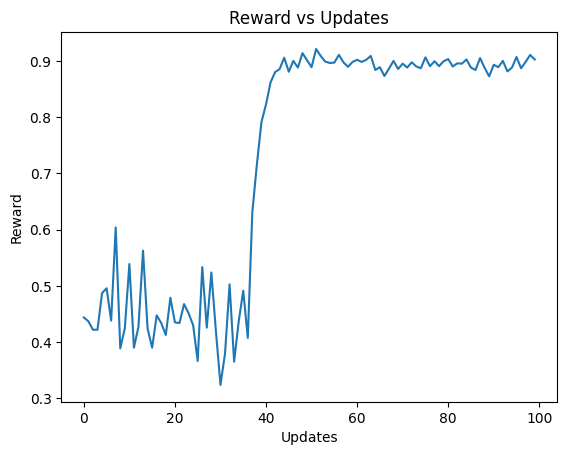

In [10]:
import matplotlib.pyplot as plt
plt.plot(run.history()["avg_reward"])
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title("Reward vs Updates")
plt.show()